Это baseline решение для задачи. План в том, чтобы поработать с признками(категориальными), разделить тренировочную выборку на 2 части - на одной из частей мы будем искать гиперпараметры для нашиъ моделей, а на второй сравнивать эти модели.

In [42]:
import pandas as pd
import numpy as np
import scipy
%matplotlib inline
from  matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

Первым делом надо загрузить наши данные и отделить тренировочную выборку от тестовой

In [2]:
data = pd.read_csv("data.txt", delimiter=';', index_col='POLICY_ID')
train_df = data[data['DATA_TYPE']=='TRAIN'].drop('DATA_TYPE', axis=1)
X_train = train_df.drop('POLICY_IS_RENEWED', axis=1)
y_train = train_df['POLICY_IS_RENEWED']
test_df = data[data['DATA_TYPE']=='TEST '].drop('DATA_TYPE', axis=1)
X_test = test_df.drop('POLICY_IS_RENEWED', axis=1)
data.head()

,DATA_TYPE,POLICY_BEGIN_MONTH,POLICY_END_MONTH,POLICY_IS_RENEWED,POLICY_SALES_CHANNEL,POLICY_SALES_CHANNEL_GROUP,POLICY_BRANCH,POLICY_MIN_AGE,POLICY_MIN_DRIVING_EXPERIENCE,VEHICLE_MAKE,...,POLICY_PRV_CLM_GLT_N,CLIENT_HAS_DAGO,CLIENT_HAS_OSAGO,POLICY_COURT_SIGN,CLAIM_AVG_ACC_ST_PRD,POLICY_HAS_COMPLAINTS,POLICY_YEARS_RENEWED_N,POLICY_DEDUCT_VALUE,CLIENT_REGISTRATION_REGION,POLICY_PRICE_CHANGE
POLICY_ID,,,,,,,,,,,,,,,,,,,,,
1,TRAIN,1,1,1,39,1,Москва,51,12,Land Rover,...,N,1,0,0,0.0,0,0,0.0,Тульская,-1.00
2,TRAIN,1,1,1,50,5,Москва,35,7,Opel,...,0,1,1,0,0.0,0,4,0.0,Москва,-0.05
3,TRAIN,1,1,1,52,6,Москва,41,6,Kia,...,1L,0,0,0,0.0,0,1,12518.0,Московская,-0.07
4,TRAIN,1,1,1,50,5,Москва,36,12,Citroen,...,0,1,1,0,0.0,0,6,15000.0,Москва,0.05
5,TRAIN,1,1,0,52,6,Санкт-Петербург,42,5,Renault,...,N,0,0,0,0.0,0,0,50000.0,Ленинградская,0.17


Затем посмотрим какие признаки у нас имеются и попробуем что-то с ними сделать

In [3]:
X_train.columns.values

array(['POLICY_BEGIN_MONTH', 'POLICY_END_MONTH', 'POLICY_SALES_CHANNEL',
       'POLICY_SALES_CHANNEL_GROUP', 'POLICY_BRANCH', 'POLICY_MIN_AGE',
       'POLICY_MIN_DRIVING_EXPERIENCE', 'VEHICLE_MAKE', 'VEHICLE_MODEL',
       'VEHICLE_ENGINE_POWER', 'VEHICLE_IN_CREDIT', 'VEHICLE_SUM_INSURED',
       'POLICY_INTERMEDIARY', 'INSURER_GENDER', 'POLICY_CLM_N',
       'POLICY_CLM_GLT_N', 'POLICY_PRV_CLM_N', 'POLICY_PRV_CLM_GLT_N',
       'CLIENT_HAS_DAGO', 'CLIENT_HAS_OSAGO', 'POLICY_COURT_SIGN',
       'CLAIM_AVG_ACC_ST_PRD', 'POLICY_HAS_COMPLAINTS',
       'POLICY_YEARS_RENEWED_N', 'POLICY_DEDUCT_VALUE',
       'CLIENT_REGISTRATION_REGION', 'POLICY_PRICE_CHANGE'], dtype=object)

Первые 2 признака - это месяца. Так и хочется узнать, на какой срок заключена страховка. Введём новый признак <i>'POLICY_LEN_MONTHS'</i> и посмотрим на его значения

77407
 0     75524
-1      1847
 6        13
-6         6
 7         6
 11        4
 8         3
-3         1
-4         1
-5         1
 5         1
Name: POLICY_LEN_MONTHS, dtype: int64


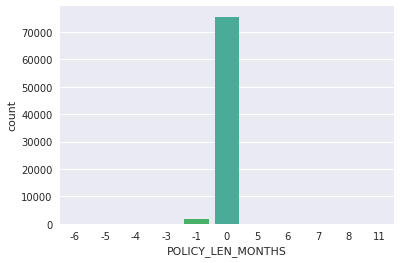

In [4]:
X_train['POLICY_LEN_MONTHS'] = X_train['POLICY_END_MONTH'] - X_train['POLICY_BEGIN_MONTH']
print(len(X_train['POLICY_LEN_MONTHS']))
sns.set(style="darkgrid")
ax = sns.countplot(x=X_train['POLICY_LEN_MONTHS'], data=X_train)
lens = X_train['POLICY_LEN_MONTHS'].value_counts()
print(lens)

Как видно из графика, практически всегда это ровно год, бывает, что на 11 месяцев и ещё редкие исключения. Поэтому признак <i>'POLICY_LEN_MONTHS'</i> имеет смысл перевести из класса числовых в категориальный. Вопрос в том, сколько должно быть категорий - мне кажется, что 3: ровно год, 11 месяцев и объединённый класс исключений.

In [5]:
X_train['POLICY_LEN_MONTHS'] = [2 if (x == -1) else 
                                0 if (x == 0) else
                                1 for x in X_train['POLICY_LEN_MONTHS'].values]
X_train['POLICY_LEN_MONTHS'].value_counts()

0    75524
2     1847
1       36
Name: POLICY_LEN_MONTHS, dtype: int64

Теперь вопрос состоит в том, что же делать дальше с этими двумя признаками, отвечающими за месяца. Ввиду появления <i>'POLICY_LEN_MONTHS'</i>, я считаю, что месяц заключения нам теперь не особо важен, к тому же он будет весьма сильно коррелировать с месяцем окончания, поэтому его выкинем. Однако месяц окончания сам по себе остаётся категориальным признаком. Чтобы не плодить из него потом кучу малоинформативных признаков(12), я считаю довольно логичным объединить месяца в группы по временам года. Чисто логически я слабо понимаю, как вообще месяц может повлиять на выбор человека, однако мало ли как погода может влиять на выбор людей, поэтому не буду совсем от них отказываться.

In [6]:
X_train['POLICY_END_SEASON'] = ['summer' if (x >= 6) & (x <= 8)
                                else 'autumn' if (x >= 9) & (x <= 11)
                                else 'spring' if (x >= 3) & (x <= 5)
                                else 'winter' for x in X_train['POLICY_END_MONTH'].values]
X_train['POLICY_END_SEASON'].value_counts()

summer    21079
spring    20131
autumn    18490
winter    17707
Name: POLICY_END_SEASON, dtype: int64

Теперь стоит обсудить <i>'POLICY_SALES_CHANNEL'</i>, <i>'POLICY_SALES_CHANNEL_GROUP'</i>

In [7]:
print(X_train['POLICY_SALES_CHANNEL'].unique())
print(X_train['POLICY_SALES_CHANNEL_GROUP'].unique())

[39 50 52  2 10 53  1  6 55 17 54 20 23 59 15 40  8 41 14 11 62 60 46  5 22
 31 51  3 25 27 16 45  4 13 18 26 44  7 29 28  9 47 49 38 35 12 57 21 63 19
 43 24 30 34 32 33 61 42 36 48 37 58 56]
[1 5 6 4 3 8 7 2]


Эти два признака снова являются категориальными. Ввиду того, что это baseline решение, каналов продаж довольно много, и у нас уже изначально имеется группировка каналов, то признак <i>'POLICY_SALES_CHANNEL'</i> предлагаю опустить, хотя он и может оказаться важным, в частности совсем не обязательно создавать все 63 признака, можно взять лишь самые популярные из них.

Теперь на очереди <i>'POLICY_BRANCH'</i>, он принимает всего 2 значения - Москва и Питер, т.е. он бинарный, просто переименуем его значения в 0 и 1 соответственно.

In [8]:
print(X_train['POLICY_BRANCH'].unique())
X_train['POLICY_BRANCH'] = [0 if (x == 'Москва') else 1 for x in X_train['POLICY_BRANCH'].values]

['Москва' 'Санкт-Петербург']


<i>'POLICY_MIN_AGE'</i>, <i>'POLICY_MIN_DRIVING_EXPERIENCE'</i> - числовые признаки, с ними можно ничего не придумывать, разве что в заполнении <i>'POLICY_MIN_DRIVING_EXPERIENCE'</i> есть явные ошибки, когда вместо стажа вождения, введён год начала. Насколько я понимаю это данные 2016 года. При этом число логически возраст клиентов далжен очень сильно влиять на их желание продлять полис или нет. Скорее всего в алгоритмах, основанных на деревьях они будут иметь большое значение, однако регрессия не способна до конца на них настроиться ввиду того, что она монотонна, поэтому предлагаю наплодить из этих числовых признаков несколько категориальных

In [9]:
print(X_train['POLICY_MIN_AGE'].unique())
print(X_train['POLICY_MIN_DRIVING_EXPERIENCE'].unique())
X_train['POLICY_MIN_DRIVING_EXPERIENCE'] = [x if (x < 100) else (2016-x) for x in X_train['POLICY_MIN_DRIVING_EXPERIENCE'].values]
X_train['AGE_70+'] = [1 if (x >= 70) else 0 for x in X_train['POLICY_MIN_AGE'].values]
X_train['AGE_60+'] = [1 if (x >= 60) & (x < 70) else 0 for x in X_train['POLICY_MIN_AGE'].values]
X_train['AGE_50+'] = [1 if (x >= 50) & (x < 60) else 0 for x in X_train['POLICY_MIN_AGE'].values]
X_train['AGE_38+'] = [1 if (x >= 38) & (x < 50) else 0 for x in X_train['POLICY_MIN_AGE'].values]
X_train['AGE_25+'] = [1 if (x >= 25) & (x < 38) else 0 for x in X_train['POLICY_MIN_AGE'].values]
X_train['AGE_18+'] = [1 if (x < 25) else 0 for x in X_train['POLICY_MIN_AGE'].values]
X_train['EXP_20+'] = [1 if (x >= 20) else 0 for x in X_train['POLICY_MIN_DRIVING_EXPERIENCE'].values]
X_train['EXP_10+'] = [1 if (x >= 10) & (x < 20) else 0 for x in X_train['POLICY_MIN_DRIVING_EXPERIENCE'].values]
X_train['EXP_5+'] = [1 if (x >= 5) & (x < 10) else 0 for x in X_train['POLICY_MIN_DRIVING_EXPERIENCE'].values]
X_train['EXP_LOW'] = [1 if (x < 5) else 0 for x in X_train['POLICY_MIN_DRIVING_EXPERIENCE'].values]

[51 35 41 36 42 60 48 27 38 39 64 56 47 44 40 49 50 53 31 32 30 33 62 28 58
 26 63 34 25 29 24 45 66 54 37 61 23 52 55 57 46 43 67 59 69 68 75 22 78 18
 76 74 65 80 72 19 73 77 71 20 79 70 21 86 82 81 83 84]
[  12    7    6    5   40   19   18   16    8   11   45   20   17   13   15
   28   29    2   42    3   36    9   10   44   23   14   43   21   25   26
    4   32   34    1   22   31   24   27   48   30    0   35 1986   33   37
 1988   52   41 2008 2002   39 1996 1995 1991   38 1979   47   46 1994 2014
 1968 2004 1998 1999 1980   49   58 1984 1992 1990 1976 2000 1989 2006 1974
 2003 1997 1993 1981 1973 2005 2010 2011   50 2013 2007   51   53 1987 1969
 2009 2001   54 1982   60 1975 1985   55 1978 2015 1977 2012 1962 1983 1972
   56   57 1970 1958 1963]


Признаки <i>'VEHICLE_MAKE'</i>, <i>'VEHICLE_MODEL'</i> - снова категориальные, причём на самом деле это один и тот же признак. Подход к таким признакам довольно просто - использовать <b>DictVectorizer</b>, получить из этого довольно разряженную матрицу... и за счёт этого можно выиграть пару процентов. В простейшем случае нам важно знать лишь категорию машины(насколько она дорогая), что как правило коррелирует с её мощностью, но для чистоты эксперимента всё-таки попробуем это сделать.

In [10]:
%%time
vehicle = ['VEHICLE_MAKE', 'VEHICLE_MODEL']
dict_vect = DictVectorizer()
X_train_vehicle = dict_vect.fit_transform(X_train[vehicle].fillna('-').T.to_dict().values())

CPU times: user 6.65 s, sys: 52 ms, total: 6.7 s
Wall time: 6.71 s


<i>'VEHICLE_ENGINE_POWER'</i> - числовой признак, достаточно будет просто нормализовать, среднее вычитать не нужно.
<br><i>'VEHICLE_IN_CREDIT'</i> - бинарный признак, ничего делать не надо
<br><i>'VEHICLE_SUM_INSURED'</i> - признак, схожий с мощностью двигателя
<br><i>'POLICY_INTERMEDIARY'</i> - категориальный признак с кучей категорий, может оказаться важным, но я предлагаю его пропустить, чтобы упростить обучение модели и не переобучиться.
<br><i>'INSURER_GENDER'</i> - бинарный признак, который надо будет переделать LabelEncoderом
<br><i>'POLICY_CLM_N'</i> - немного странный признак, видимо он категориальный 
<br><i>'POLICY_CLM_GLT_N'</i> - аналогично
<br><i>'POLICY_PRV_CLM_N'</i> - аналогично
<br><i>'POLICY_PRV_CLM_GLT_N'</i> - аналогично
<br><i>'CLIENT_HAS_DAGO'</i> - бинарный
<br><i>'CLIENT_HAS_OSAGO'</i> - бинарный
<br><i>'POLICY_COURT_SIGN'</i> - бинарный
<br><i>'CLAIM_AVG_ACC_ST_PRD'</i> - числовой
<br><i>'POLICY_HAS_COMPLAINTS'</i> - бинарный
<br><i>'POLICY_YEARS_RENEWED_N'</i> - числовой, есть пропуски
<br><i>'POLICY_DEDUCT_VALUE'</i> - числовой
<br><i>'CLIENT_REGISTRATION_REGION'</i> - похож на модели машин
<br><i>'POLICY_PRICE_CHANGE'</i> - числовой

In [11]:
%%time
print(X_train['INSURER_GENDER'].nunique())
print(X_train['POLICY_CLM_N'].value_counts())
X_train['POLICY_YEARS_RENEWED_N'] = [1 if x=='N' else x for x in X_train['POLICY_YEARS_RENEWED_N'].values]
region = ['POLICY_INTERMEDIARY', 'CLIENT_REGISTRATION_REGION']
reg_vect = DictVectorizer()
X_train_region = reg_vect.fit_transform(X_train[region].fillna('-').T.to_dict().values())

2
0      54481
1S      8073
1L      8000
2       4972
3       1377
4+       458
n/d       46
Name: POLICY_CLM_N, dtype: int64
CPU times: user 6.68 s, sys: 32 ms, total: 6.71 s
Wall time: 6.71 s


Теперь надо сгруппировать признаки одного порядка и преобразовать их

In [12]:
standard = StandardScaler()
maxabs = MaxAbsScaler()
label = LabelEncoder()
onehot = OneHotEncoder()
season = LabelBinarizer()
labelbin = LabelBinarizer()
absfeature = ['VEHICLE_ENGINE_POWER', 'VEHICLE_SUM_INSURED']
scalefeature = ['POLICY_MIN_AGE', 'POLICY_MIN_DRIVING_EXPERIENCE', 'CLAIM_AVG_ACC_ST_PRD', 'POLICY_YEARS_RENEWED_N', 
                'POLICY_DEDUCT_VALUE', 'POLICY_PRICE_CHANGE']
binaryfeature = ['POLICY_BRANCH', 'AGE_70+', 'AGE_60+', 'AGE_50+', 'AGE_38+', 'AGE_25+', 'AGE_18+',
                 'EXP_20+', 'EXP_10+', 'EXP_5+', 'EXP_LOW', 'VEHICLE_IN_CREDIT', 'CLIENT_HAS_DAGO', 'CLIENT_HAS_OSAGO',
                 'POLICY_COURT_SIGN', 'POLICY_HAS_COMPLAINTS', 'INSURER_GENDER']
onehotfeature = ['POLICY_LEN_MONTHS', 'POLICY_SALES_CHANNEL', 'POLICY_SALES_CHANNEL_GROUP']
#labelfeature = ['POLICY_END_SEASON', 'POLICY_CLM_N', 'POLICY_CLM_GLT_N', 'POLICY_PRV_CLM_N', 'POLICY_PRV_CLM_GLT_N']
X_train_abs = maxabs.fit_transform(X_train[absfeature])
X_train_scaled = standard.fit_transform(X_train[scalefeature])
X_train['INSURER_GENDER'] = label.fit_transform(X_train['INSURER_GENDER'])
X_train_bool = X_train[binaryfeature]
X_train_one_hot = onehot.fit_transform(X_train[onehotfeature])
X_train_season = season.fit_transform(X_train['POLICY_END_SEASON'])
X_train_N = labelbin.fit_transform(X_train['POLICY_CLM_N'])
X_train_GLT_N = labelbin.transform(X_train['POLICY_CLM_GLT_N'])
X_train_PRV_N = labelbin.transform(X_train['POLICY_PRV_CLM_N'])
X_train_PRV_GLT_N = labelbin.transform(X_train['POLICY_PRV_CLM_GLT_N'])

Теперь соединим все признаки воедино и разобьём тренировочную выборку на тренировочную и валидационную

In [13]:
X_train_new = scipy.sparse.hstack([X_train_abs, X_train_scaled, X_train_bool, X_train_season, X_train_N,
                                   X_train_one_hot, X_train_GLT_N, X_train_PRV_N, X_train_PRV_GLT_N,
                                   X_train_region, X_train_vehicle])
X_train_2, X_valid, y_train_2, y_valid = train_test_split(X_train_new, y_train,  test_size = 0.2, random_state = 1)

После разделения выборки на тренировочную и валидационную части, можно начинать обучение моделей. Это будет проходить примерно по такому сценарию: берётся произвольный алгоритм, при помощи кросс валидации подбираем нужные гиперпараметры. А затем на валидационной выборке сравниваем качество алгоритмов и строим некую модель второго порядка, например, взвешенную сумму.

Также стоит обсудить и метрику качества. В условия задачи мы хотим максимизировать TP+TN. Данное число прямо пропорционально метрике <i>accuracy</i>, которая представляется как (TP+TN)/TP+TN+FP+FN, поскольку знаменатель зависит только количества элементов в выборке, про которую нам необходимо получить резуьльтат.

In [13]:
skf = StratifiedKFold(n_splits = 5, random_state = 1, shuffle = True)

Поскольку это задача классификации, то первым алгоритмом будет обычная логистическая регрессия. Во многом из-за неё пришлось столько времени потратить на признаки, ведь она не умеет работать с категориальными признаками - только числовыми или бинарными.

In [15]:
C_space = np.logspace(-3, 2, 6)
for c in tqdm(C_space):
    lr = LogisticRegression(C = c, random_state = 1)
    print(c, cross_val_score(lr, X_train_2, y_train_2, scoring='accuracy', cv=skf).mean())

 17%|█▋        | 1/6 [00:01<00:08,  1.76s/it]

0.001 0.663189342372


 33%|███▎      | 2/6 [00:05<00:10,  2.52s/it]

0.01 0.673992686664


 50%|█████     | 3/6 [00:12<00:12,  4.04s/it]

0.1 0.676059735818


 67%|██████▋   | 4/6 [00:27<00:13,  6.94s/it]

1.0 0.673992751853


 83%|████████▎ | 5/6 [01:02<00:12, 12.58s/it]

10.0 0.670892210067


100%|██████████| 6/6 [02:16<00:00, 22.83s/it]

100.0 0.669697220031


Как видно из обучения, оптимальный парамерт С для нашей первой логистической регресии равен 0.1. Однако возможно на неполном множестве признаков результат окажется лучше? Попробуем выкинуть некоторые группы

In [16]:
X_train_new = scipy.sparse.hstack([X_train_abs, X_train_scaled, X_train_bool, X_train_season, X_train_N,
                                   X_train_one_hot, X_train_GLT_N, X_train_PRV_N, X_train_PRV_GLT_N,
                                   X_train_region])
X_train_2, X_valid, y_train_2, y_valid = train_test_split(X_train_new, y_train,  test_size = 0.2, random_state = 1)
lr = LogisticRegression(C = c, random_state = 1)
print(cross_val_score(lr, X_train_2, y_train_2, scoring='accuracy', cv=skf).mean())

0.668502194792


In [17]:
X_train_new = scipy.sparse.hstack([X_train_abs, X_train_scaled, X_train_bool, X_train_season, X_train_N,
                                   X_train_one_hot, X_train_GLT_N, X_train_PRV_N, X_train_PRV_GLT_N,
                                   X_train_vehicle])
X_train_2, X_valid, y_train_2, y_valid = train_test_split(X_train_new, y_train,  test_size = 0.2, random_state = 1)
lr = LogisticRegression(C = 0.1, random_state = 1)
print(cross_val_score(lr, X_train_2, y_train_2, scoring='accuracy', cv=skf).mean())

0.672135597562


In [18]:
X_train_new = scipy.sparse.hstack([X_train_abs, X_train_scaled, X_train_bool, X_train_season,
                                   X_train_one_hot,
                                   X_train_region, X_train_vehicle])
X_train_2, X_valid, y_train_2, y_valid = train_test_split(X_train_new, y_train,  test_size = 0.2, random_state = 1)
lr = LogisticRegression(C = 0.1, random_state = 1)
print(cross_val_score(lr, X_train_2, y_train_2, scoring='accuracy', cv=skf).mean())

0.662107473142


In [19]:
X_train_new = scipy.sparse.hstack([X_train_abs, X_train_scaled, X_train_bool, X_train_season, X_train_N,
                                   X_train_GLT_N, X_train_PRV_N, X_train_PRV_GLT_N,
                                   X_train_region, X_train_vehicle])
X_train_2, X_valid, y_train_2, y_valid = train_test_split(X_train_new, y_train,  test_size = 0.2, random_state = 1)
lr = LogisticRegression(C = 0.1, random_state = 1)
print(cross_val_score(lr, X_train_2, y_train_2, scoring='accuracy', cv=skf).mean())

0.674897012928


In [20]:
X_train_new = scipy.sparse.hstack([X_train_abs, X_train_scaled, X_train_season, X_train_N,
                                   X_train_one_hot, X_train_GLT_N, X_train_PRV_N, X_train_PRV_GLT_N,
                                   X_train_region, X_train_vehicle])
X_train_2, X_valid, y_train_2, y_valid = train_test_split(X_train_new, y_train,  test_size = 0.2, random_state = 1)
C_space = np.logspace(-3, 2, 6)
lr = LogisticRegression(C = 0.1, random_state = 1)
print(cross_val_score(lr, X_train_2, y_train_2, scoring='accuracy', cv=skf).mean())

0.673330613675


In [21]:
X_train_new = scipy.sparse.hstack([X_train_abs, X_train_scaled, X_train_bool, X_train_N,
                                   X_train_one_hot, X_train_GLT_N, X_train_PRV_N, X_train_PRV_GLT_N,
                                   X_train_region, X_train_vehicle])
X_train_2, X_valid, y_train_2, y_valid = train_test_split(X_train_new, y_train,  test_size = 0.2, random_state = 1)
lr = LogisticRegression(C = 0.1, random_state = 1)
print(cross_val_score(lr, X_train_2, y_train_2, scoring='accuracy', cv=skf).mean())

0.675995119382


In [22]:
X_train_new = scipy.sparse.hstack([X_train_abs, X_train_bool, X_train_N,  X_train_season,
                                   X_train_one_hot, X_train_GLT_N, X_train_PRV_N, X_train_PRV_GLT_N,
                                   X_train_region, X_train_vehicle])
X_train_2, X_valid, y_train_2, y_valid = train_test_split(X_train_new, y_train,  test_size = 0.2, random_state = 1)
lr = LogisticRegression(C = 0.1, random_state = 1)
print(cross_val_score(lr, X_train_2, y_train_2, scoring='accuracy', cv=skf).mean())

0.670294693537


In [23]:
X_train_new = scipy.sparse.hstack([X_train_scaled, X_train_bool, X_train_N, X_train_season,
                                   X_train_one_hot, X_train_GLT_N, X_train_PRV_N, X_train_PRV_GLT_N,
                                   X_train_region, X_train_vehicle])
X_train_2, X_valid, y_train_2, y_valid = train_test_split(X_train_new, y_train,  test_size = 0.2, random_state = 1)
lr = LogisticRegression(C = 0.1, random_state = 1)
print(cross_val_score(lr, X_train_2, y_train_2, scoring='accuracy', cv=skf).mean())

0.676205050755


Как видно из нашего исследования признак season оказался и правда не слишком полезным, а единственная модель, которая показал результаты лучше, чем исходная - без признаков, которые мы нормализовали <i>MaxAbsScalerом</i>.

Вторым алгоритмом, который мы собираемся использовать будет KNN. Маловероятно, что он отработает лучше всех, но тем не менее он может быть полезным. Будем пользоваться им на исходном мн-ве признаков(за исключением категорильных с кучей категорий). У метода ближайших соседей достаточно много параметров, поэтому нам понадобится <i>GridSearchCV</i>
<p style="color:#148814">update</p>
Учить KNN на всей выборке было плохой идеей. Даже учитывая то, что я убрал все категориальные признаки. Поэтому придётся постпуить по-другому. Сначала найдём нужный размер выборки и на нём гиперпараметры, чтобы время обучения было терпимым, а потом воспользуемся беггингом для охвата большего числа элементов.

In [39]:
X_train_new = scipy.sparse.hstack([X_train_abs, X_train_scaled, X_train_bool])
X_train_2, X_valid, y_train_2, y_valid = train_test_split(X_train_new, y_train,  test_size = 0.2, random_state = 1)
X_train_2_short = X_train_2[:10000,:]
y_train_2_short = y_train_2[:10000]

In [44]:
%%time
knn = KNeighborsClassifier()
clf = GridSearchCV(estimator = knn, n_jobs = 1, cv = skf, return_train_score = True, verbose = 1,
                   param_grid = {"n_neighbors": [1,3,5,10,20,50], "weights": ['uniform', 'distance']})
clf.fit(X_train_2_short, y_train_2_short)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  4.1min finished


CPU times: user 3min 55s, sys: 11.7 s, total: 4min 7s
Wall time: 4min 7s


In [48]:
clf.cv_results_['mean_test_score']

array([ 0.5742,  0.5742,  0.5976,  0.5938,  0.6065,  0.6036,  0.6117,
        0.6227,  0.6304,  0.6343,  0.638 ,  0.6408])

Отсюда можно сделать вывод, что оптимальных гиперпараметров мы не нашли, продолжим поиск

In [51]:
%%time
clf = GridSearchCV(estimator = knn, n_jobs = 1, cv = skf, return_train_score = True, verbose = 0,
                   param_grid = {"n_neighbors": [30,70,100,150], "weights": ['uniform', 'distance']})
clf.fit(X_train_2_short, y_train_2_short)

CPU times: user 2min 44s, sys: 7.69 s, total: 2min 52s
Wall time: 2min 52s


In [50]:
clf.cv_results_['mean_test_score']

array([ 0.6345,  0.6406,  0.639 ,  0.6395,  0.6401,  0.6394,  0.636 ,
        0.6385])

Как видно наилучший результат показал KNN с 50 соседями и весами 'distance'. Впоследствие и будем использовать эти параметры в нашм будущем bagging классификаторе. Однако перед этим стоит проверить текущую модель на большем подмн-ве признаков

In [14]:
knn = KNeighborsClassifier(n_neighbors = 50, weights = 'distance')
X_train_new = scipy.sparse.hstack([X_train_abs, X_train_scaled, X_train_bool, X_train_season, X_train_N,
                                   X_train_one_hot, X_train_GLT_N, X_train_PRV_N, X_train_PRV_GLT_N])
X_train_2, X_valid, y_train_2, y_valid = train_test_split(X_train_new, y_train,  test_size = 0.2, random_state = 1)
X_train_2_short = X_train_2[:10000,:]
y_train_2_short = y_train_2[:10000]

In [16]:
%%time
print(cross_val_score(knn, X_train_2_short, y_train_2_short, scoring='accuracy', cv=skf).mean())

0.6489
CPU times: user 4.95 s, sys: 184 ms, total: 5.14 s
Wall time: 5.13 s


Точность выросла, видимо вся проблема была в размере выборки. поэтому можно смело пробовать полный набор признаков

In [17]:
X_train_new = scipy.sparse.hstack([X_train_abs, X_train_scaled, X_train_bool, X_train_season, X_train_N,
                                   X_train_one_hot, X_train_GLT_N, X_train_PRV_N, X_train_PRV_GLT_N,
                                   X_train_region, X_train_vehicle])
X_train_2, X_valid, y_train_2, y_valid = train_test_split(X_train_new, y_train,  test_size = 0.2, random_state = 1)
X_train_2_short = X_train_2[:10000,:]
y_train_2_short = y_train_2[:10000]

In [18]:
%%time
print(cross_val_score(knn, X_train_2_short, y_train_2_short, scoring='accuracy', cv=skf).mean())

0.6514
CPU times: user 4.88 s, sys: 296 ms, total: 5.17 s
Wall time: 5.18 s


In [25]:
%%time
print(X_train_2.shape)
bg = BaggingClassifier(base_estimator = knn, max_samples = 10000, random_state = 1, verbose = 1)
print(cross_val_score(bg, X_train_2, y_train_2, scoring='accuracy', cv=skf).mean())

(61925, 2152)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


0.655712544188
CPU times: user 6min 18s, sys: 30.5 s, total: 6min 48s
Wall time: 6min 48s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min finished


Отлично, беггинг над соседями оказался полезен, поэтому запомним этот алгоритм и перейдём к следующему алгоритму - беггингу над решающими деревьями, он же является случайным лесом. Особенность этих алгоритмов заключается в том, что decision trees устойчивы к размеру выборки, т.е. их можно обучать на небольшои под множестве.
<br>Что касается гиперпараметров случайного леса, то в качестве критерия разибения стоит выбрать gini(обоснование: 
<a href="https://www.quora.com/Machine-Learning/Are-gini-index-entropy-or-classification-error-measures-causing-any-difference-on-Decision-Tree-classification">ответ с quora</a>)

In [41]:
%%time
rf = RandomForestClassifier(random_state = 1, n_estimators=100, max_depth=1000, oob_score=True, class_weight='balanced')
print(cross_val_score(rf, X_train_2, y_train_2, scoring='accuracy', cv=skf).mean())

0.69416229752
CPU times: user 8min 8s, sys: 584 ms, total: 8min 8s
Wall time: 8min 8s


ОБычный случайный лес без подбора гиперпараметров уже дал неплохой прирост в качестве предсказания, даже по сравнению с логистической регрессией. Соотвественно дальше есть 2 пути - тюнить RF или вернуться к LR и использовать на ней <i>BaggingClassifier<i>. Начну с RF

In [45]:
%%time
params = {"max_depth": [30, 100, 300, 800, 2000],
          "min_samples_leaf": [1, 3, 5, 8],
          "max_features": [2, 5, 15, 40, 100]}
rs = RandomizedSearchCV(estimator = rf, n_jobs = 2, cv = skf, verbose = 2, param_distributions = params, 
                        scoring = 'accuracy', n_iter = 20)
rs.fit(X_train_2, y_train_2)
print(rs.best_score_, rs.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] min_samples_leaf=3, max_depth=30, max_features=2 ................
[CV] min_samples_leaf=3, max_depth=30, max_features=2 ................
[CV] . min_samples_leaf=3, max_depth=30, max_features=2, total=   1.9s
[CV] min_samples_leaf=3, max_depth=30, max_features=2 ................
[CV] . min_samples_leaf=3, max_depth=30, max_features=2, total=   2.0s
[CV] min_samples_leaf=3, max_depth=30, max_features=2 ................
[CV] . min_samples_leaf=3, max_depth=30, max_features=2, total=   1.9s
[CV] min_samples_leaf=3, max_depth=30, max_features=2 ................
[CV] . min_samples_leaf=3, max_depth=30, max_features=2, total=   1.9s
[CV] min_samples_leaf=8, max_depth=800, max_features=100 .............
[CV] . min_samples_leaf=3, max_depth=30, max_features=2, total=   1.9s
[CV] min_samples_leaf=8, max_depth=800, max_features=100 .............
[CV]  min_samples_leaf=8, max_depth=800, max_features=100, total=  32.4s
[CV] min_samp

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  3.8min


[CV]  min_samples_leaf=8, max_depth=100, max_features=40, total=  13.5s
[CV] min_samples_leaf=8, max_depth=100, max_features=40 ..............
[CV]  min_samples_leaf=8, max_depth=100, max_features=40, total=  13.6s
[CV] min_samples_leaf=8, max_depth=100, max_features=15 ..............
[CV]  min_samples_leaf=8, max_depth=100, max_features=15, total=   6.4s
[CV] min_samples_leaf=8, max_depth=100, max_features=15 ..............
[CV]  min_samples_leaf=8, max_depth=100, max_features=40, total=  13.6s
[CV] min_samples_leaf=8, max_depth=100, max_features=15 ..............
[CV]  min_samples_leaf=8, max_depth=100, max_features=15, total=   6.6s
[CV] min_samples_leaf=8, max_depth=100, max_features=15 ..............
[CV]  min_samples_leaf=8, max_depth=100, max_features=15, total=   6.5s
[CV] min_samples_leaf=8, max_depth=100, max_features=15 ..............
[CV]  min_samples_leaf=8, max_depth=100, max_features=15, total=   6.3s
[CV] min_samples_leaf=5, max_depth=30, max_features=2 ................

[CV] min_samples_leaf=8, max_depth=800, max_features=2 ...............
[CV]  min_samples_leaf=8, max_depth=800, max_features=2, total=   1.8s
[CV] min_samples_leaf=8, max_depth=800, max_features=2 ...............
[CV]  min_samples_leaf=8, max_depth=800, max_features=2, total=   1.8s
[CV] min_samples_leaf=8, max_depth=800, max_features=2 ...............
[CV]  min_samples_leaf=3, max_depth=2000, max_features=15, total=   9.7s
[CV] min_samples_leaf=8, max_depth=800, max_features=2 ...............
[CV]  min_samples_leaf=8, max_depth=800, max_features=2, total=   1.8s
[CV]  min_samples_leaf=8, max_depth=800, max_features=2, total=   1.8s


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed: 21.3min finished


0.704093661688 {'min_samples_leaf': 1, 'max_depth': 30, 'max_features': 100}
CPU times: user 1min 44s, sys: 328 ms, total: 1min 44s
Wall time: 23min


In [ ]:
bg_lr = (base_estimator = lr, max_samples = 10000, random_state = 1, verbose = 1)